In [1]:
import xarray as xr
import fsspec
import numpy as np
import s3fs
import zarr
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [89]:
def analyze_aorc_amc_plots(lat, lon, thresholds_in, start_year=1979, end_year=2024):
    safe_lat = str(lat).replace('.', '_')
    safe_lon = str(lon).replace('.', '_')
    base_url = 's3://noaa-nws-aorc-v1-1-1km'
    var = 'APCP_surface'
    thresholds_mm = [t * 25.4 for t in thresholds_in]  # Convert to mm
    years = range(start_year, end_year + 1)

    all_ts = []
    for year in tqdm(years, desc="Loading years"):
        url = f"{base_url}/{year}.zarr/"
        ds = xr.open_zarr(url, consolidated=True, storage_options={"anon": True})
        precip_ts = ds[var].sel(latitude=lat, longitude=lon, method='nearest')
        all_ts.append(precip_ts.to_series())

    hourly_series = pd.concat(all_ts)
    # === Compute 5-day total ===
    antecedent_5day = hourly_series.rolling(window=120).sum().shift(1)

    # === Plot 1: Full Hourly Time Series with Annual Maxima and Thresholds ===
    fig, ax = plt.subplots(figsize=(8, 4))

    # Primary y-axis: Hourly precipitation
    hourly_series.plot(ax=ax, label='Hourly Precipitation', color='skyblue', linewidth=1)

    # Secondary y-axis: 5-day antecedent rainfall
    ax2 = ax.twinx()
    antecedent_5day.plot.line(ax=ax2, label='5-Day Precipitation', color='black', linewidth=0.5, alpha=0.3, zorder=1)

    # Annual maxima
    annual_max_idx = hourly_series.resample('YE').apply(lambda x: x.idxmax()).dropna()
    annual_max_values = hourly_series.loc[annual_max_idx].dropna()
    annual_max_values = annual_max_values[annual_max_values.index.isin(hourly_series.index)]
    ax.scatter(
        annual_max_values.index,
        annual_max_values.values,
        marker='*',
        s=120,
        facecolors='white',
        edgecolors='red',
        linewidths=1.2,
        label='Annual Maxima',
        zorder=5
    )

    # Thresholds (2-year and 5-year)
    linestyles = ['--', '-.']
    threshold_labels = ['2-Year', '5-Year']
    for i, (t_mm, t_in) in enumerate(zip(thresholds_mm[:2], thresholds_in[:2])):
        ax.axhline(
            t_mm,
            color='red',
            linestyle=linestyles[i % len(linestyles)],
            linewidth=2,
            label=f'{threshold_labels[i]}'
        )

    # Shade dormant and growing seasons
    for year in range(hourly_series.index.min().year, hourly_series.index.max().year + 1):
        ax.axvspan(pd.Timestamp(f'{year}-11-01'), pd.Timestamp(f'{year + 1}-04-30'),
                color='lightgrey', alpha=0.3,
                label='Dormant Season' if year == hourly_series.index.min().year else "")
        ax.axvspan(pd.Timestamp(f'{year + 1}-05-01'), pd.Timestamp(f'{year + 1}-10-31'),
                color='lightgreen', alpha=0.15,
                label='Growing Season' if year == hourly_series.index.min().year else "")

    # Axis formatting
    ax.set_ylabel("Hourly Precipitation (mm)")
    ax.set_ylim(bottom=0)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax2.set_ylabel("5-Day Rainfall (mm)")
    ax2.set_ylim(bottom=0)

    # Combine legends from both axes
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(
    handles1 + handles2,
    labels1 + labels2,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),  # lower value = further below
    ncol=4,
    frameon=False
    )   

    plt.tight_layout()
    #plt.savefig(fr"D:\culvert repo\Results\Figures\lat_{safe_lat}_lon_{safe_lon}_perc_timeseries.png", dpi=300, bbox_inches='tight')
    plt.show()

    # === Compute 5-day total ===
    antecedent_5day = hourly_series.rolling(window=120).sum().shift(1)

    def classify_amc(ts, rain_5d):
        m = ts.month
        if pd.isna(rain_5d):
            return None
        if 5 <= m <= 10:
            if rain_5d < 1.4*25.4: return 'Dry'
            elif rain_5d <= 2.1*25.4: return 'Normal'
            else: return 'Wet'
        else:
            if rain_5d < 0.5*25.4: return 'Dry'
            elif rain_5d <= 1.1*25.4: return 'Normal'
            else: return 'Wet'

    amc = pd.Series(
        [classify_amc(ts, rain) for ts, rain in antecedent_5day.items()],
        index=antecedent_5day.index
    )

    df = pd.DataFrame({
        'hourly_rain_mm': hourly_series,
        'antecedent_5day_mm': antecedent_5day,
        'AMC': amc
    })

    
    # === Merged AMC Distributions on Same Axis ===
    plt.figure(figsize=(4, 3))
    bar_width = 0.2
    amc_order = ['Dry', 'Normal', 'Wet']

    # --- 1. Plot AMC at Annual Maxima ---
    annual_max_idx = hourly_series.resample('YE').apply(lambda x: x.idxmax()).dropna()
    amc_annual_max = df.loc[annual_max_idx, 'AMC']
    counts_annual = amc_annual_max.value_counts(normalize=True).reindex(amc_order).fillna(0)
    plt.bar(
        [x for x in range(len(amc_order))],
        counts_annual.values,
        width=bar_width,
        label='Annual maxima',
        edgecolor='black',
        color='gray'
    )

    # --- 2. Plot AMC for each threshold ---
    threshold_labels = ['>2-yr', '>5-yr']
    threshold_colors = ['lightblue', 'darkblue']  

    for i, (t_mm, t_in) in enumerate(zip(thresholds_mm, thresholds_in)):
        subset = df[df['hourly_rain_mm'] > t_mm]
        counts = subset['AMC'].value_counts(normalize=True).reindex(amc_order).fillna(0)
        # Offset bar position to avoid overlap
        offset = (i + 1) * bar_width
        plt.bar(
            [x + offset for x in range(len(amc_order))],
            counts.values,
            width=bar_width,
            label=threshold_labels[i],
            color=threshold_colors[i],
            edgecolor='black'
        )

    # --- Formatting ---
    total_bars = len(thresholds_in) + 1
    midpoints = [x + bar_width * (total_bars - 1) / 2 for x in range(len(amc_order))]
    plt.xticks(midpoints, amc_order, fontsize=12)
    plt.ylabel("Probability", fontsize=12)
    plt.xlabel("Antecedent soil moisture state", fontsize=12)

    #plt.title("AMC Probabilities (Annual Maxima & Threshold Events)", fontsize=13)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.legend(
    ncol=3,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),  # below the plot
    frameon=False
    )
    plt.tight_layout()
    #plt.savefig(fr"D:\culvert repo\Results\Figures\lat_{safe_lat}_lon_{safe_lon}_AMC_state_prob.png", dpi=300, bbox_inches='tight')
    plt.show()
    #df.to_excel(fr"D:\culvert repo\Results\AMC\lat_{safe_lat}_lon_{safe_lon}_hourly_data.xlsx")


Loading years: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]


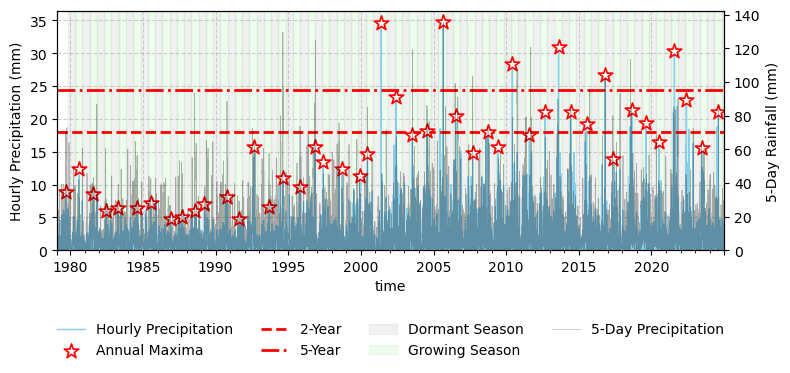

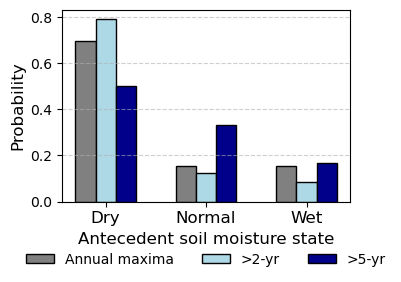

In [90]:
thresholds = [0.709, 0.960]  # in inches
lat_nys = 42.2
lon_nys = -77.14
analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [00:39<00:00,  1.16it/s]


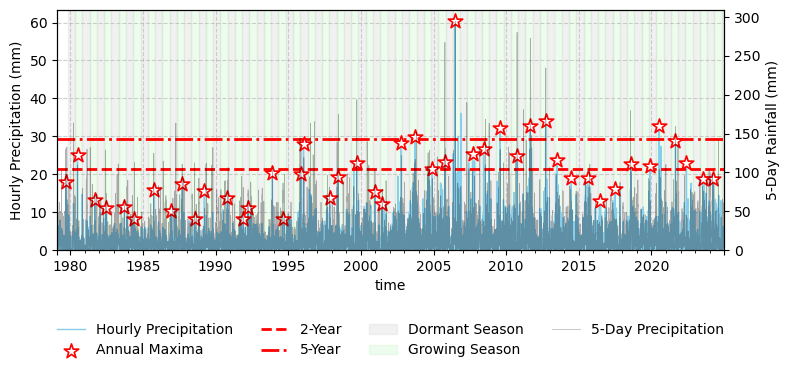

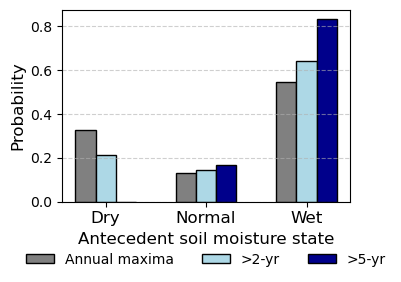

In [91]:
thresholds = [0.844, 1.15]  # in inches
lat_nys = 42.1445
lon_nys = -74.2952
analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]


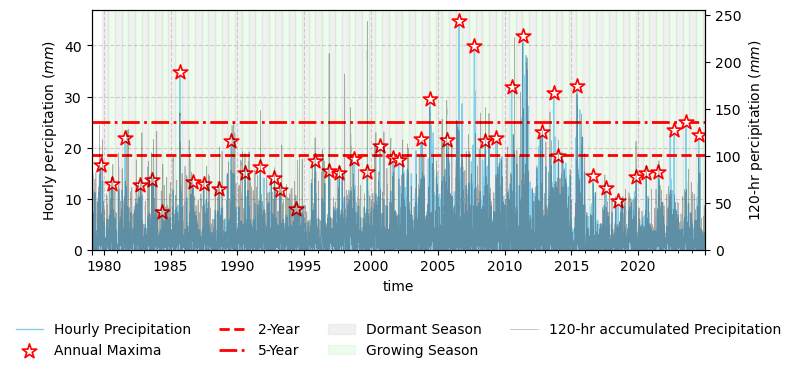

Number of events > 2-year threshold: 63
Number of events > 5-year threshold: 19


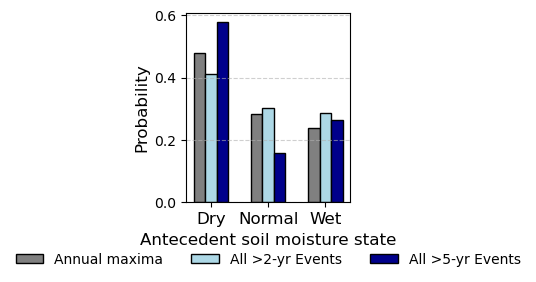

In [83]:
thresholds = [0.728, 0.988]  # in inches
lat_nys = 44.1009
lon_nys = -73.9436
analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [01:04<00:00,  1.41s/it]


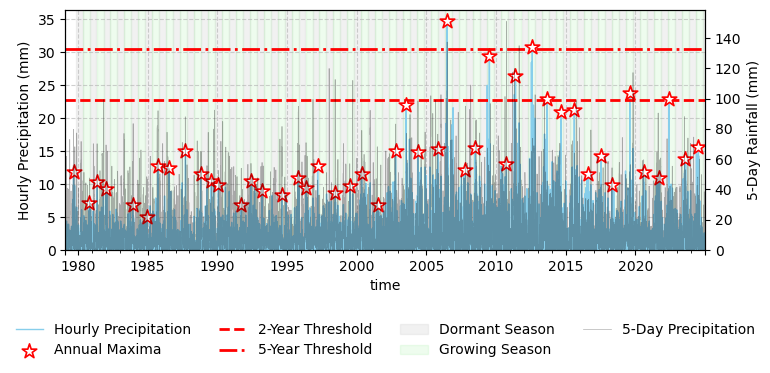

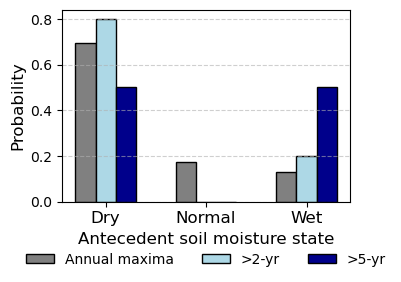

In [38]:
thresholds = [0.896, 1.20]  # in inches
lat_nys =  43.6392
lon_nys = -74.1414

analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [00:51<00:00,  1.12s/it]


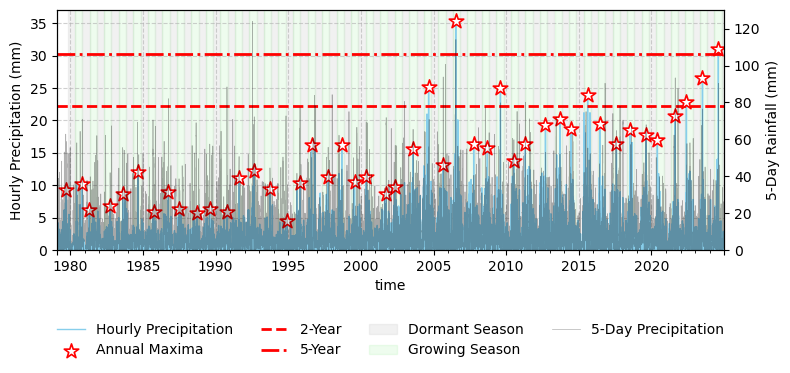

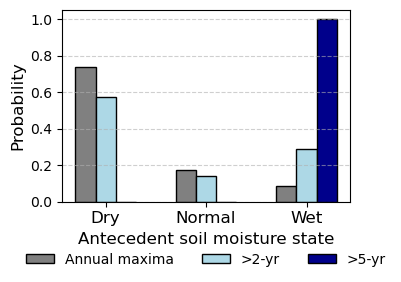

In [65]:
thresholds = [0.874, 1.19]  # in inches
lat_nys =  43.1145
lon_nys = -76.8989
analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [00:50<00:00,  1.11s/it]


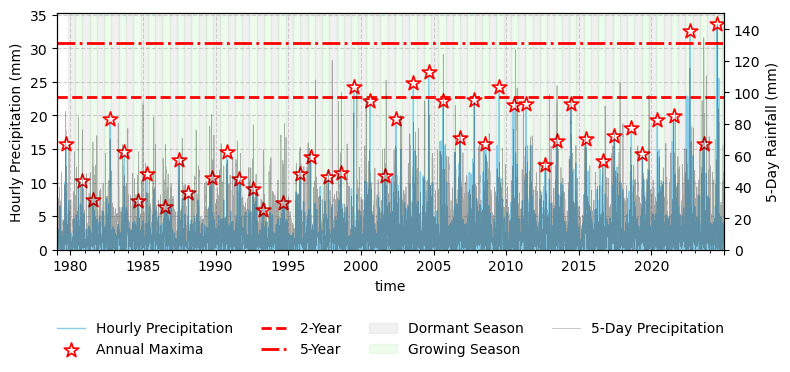

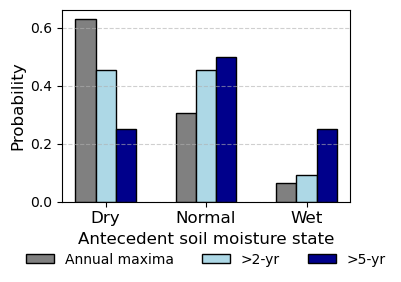

In [68]:
thresholds = [0.895, 1.21]  # in inches
lat_nys =  43.8241
lon_nys = -75.2400
analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [00:50<00:00,  1.11s/it]


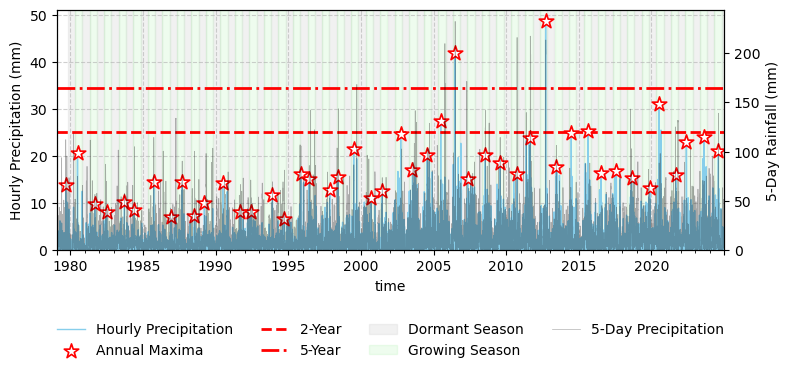

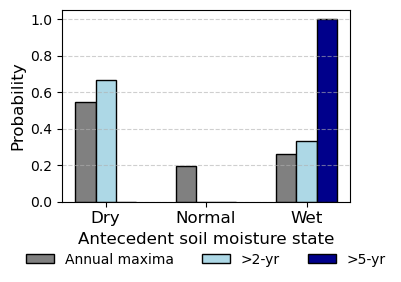

In [71]:
thresholds = [0.984, 1.36]  # in inches
lat_nys =  42.1690
lon_nys = -74.4160
analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [00:58<00:00,  1.28s/it]


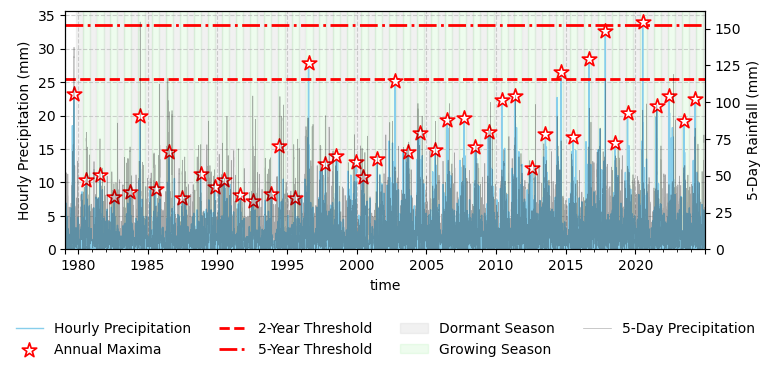

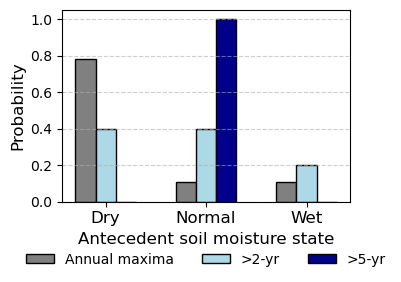

In [ ]:
thresholds = [1.00, 1.32]  # in inches
lat_nys =  42.2073
lon_nys = -79.3709
analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [00:51<00:00,  1.12s/it]


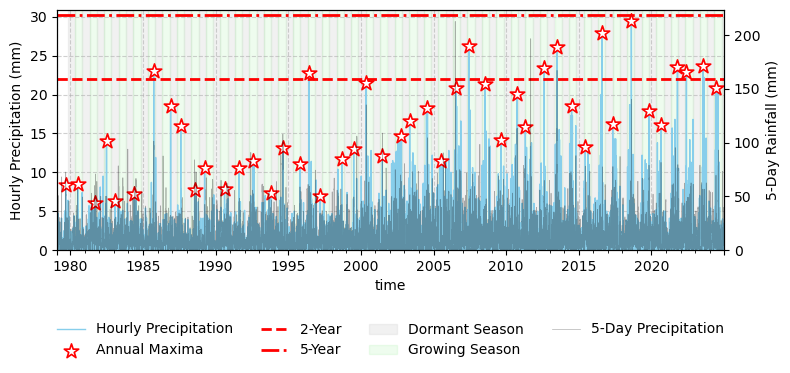

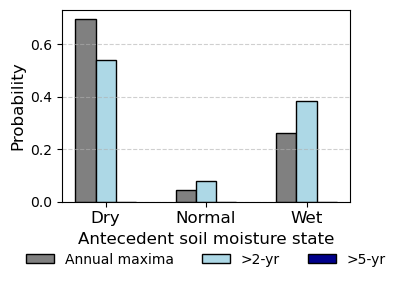

In [72]:
thresholds = [0.867, 1.19]  # in inches
lat_nys =  42.7848
lon_nys = -75.5696
analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)